# Sokoban solver

This collection of scripts implements a Sokoban solver using two common search algorithms: LRTA* and Beam Search. The goal is to find a solution to the Sokoban puzzle, which involves moving boxes to designated target locations in a grid-based environment.

In order for these algorithms to work, we need to define good heuristic and cost functions. The heuristic function should take a state of the game and return a value. The state consists of the position of the player along with the positions of the boxes. The returned value should be smaller as the box approaches the target. The cost function should return the cost of moving a box from its current position to the next required position.

## Part 1: LRTA*

This section is dedicated to implementing the LRTA* algorithm.

### First intuition

The most basic heuristic function one can think of is the Manhattan distance between the box and the target. But the player should also move towards the box. So we need to take into account the distance between the player and the box. The heuristic function should return the sum of the Manhattan distance between the box and the target and the Manhattan distance between the player and the box.

For the first attempt, we will leave the cost function as 1.

Sneak peek of the heuristic function:

```py
def h1(s: Map, visited: Optional[dict] = None) -> int:
    return (
        # distance from player to closest box
        min(manhattan(s.player, box) for box in s.boxes.values()) +

        # distance from each box to its nearest goal
        sum(min(manhattan(box, goal) for goal in s.targets) for box in s.boxes.values())
    )
```

With this parameters, the results are the following:

In [26]:
from sokoban import Map
from search_methods.solver import Solver
from search_methods.lrta_star import *
from analysis.utils import *

import matplotlib.pyplot as plt
import numpy as np

In [27]:
map = MAPS['easy_map1']
solver = Solver(map, 'lrta_star')

solver.h, solver.c = h1, c1
states, count, duration, pulls = solver.solve(display=True)

Algorithm: lrta_star
States explored: 111
Duration: 0.0102 seconds
Pulls: 6
Solution found: True


As it can be seen, the algorithm is not very efficient. It visits a lot of states before finding the solution. We can search for a better algorithm.

### Second intuition
The second heuristic function is a bit more complex. Instead of computing the distance between the player and thhe box, it searches for the position where the player can push the box towards the goal. The distance is then computed relative to that position. The heuristic function is somewhat like this:

```py
def h2(s: Map, visited: Optional[dict] = None) -> int:
    ...
    # Now check the direction in which the box should be pushed, so that the player
    # should go behind the direction of the box as much as possible
    diff = (box.x - goal[0], box.y - goal[1])
    if abs(diff[0]) > abs(diff[1]):
        direction = (sign(diff[0]), 0)
    else:
        direction = (0, sign(diff[1]))

    required_player_pos = (box.x + direction[0], box.y + direction[1])

    # Add the manhattan distance from the player to the required position
    ...
    return total
```

However, after performing the test, we can see that no improvement was made. The algorithm is still slow and visits a lot of states before finding the solution:

In [28]:
map = MAPS['easy_map1']
solver = Solver(map, 'lrta_star')

solver.h, solver.c = h2, c2
states, count, duration, pulls = solver.solve(display=True)

Algorithm: lrta_star
States explored: 145
Duration: 0.0137 seconds
Pulls: 8
Solution found: True


This may be because the now there are additional constraints on the player position.

### Third intuition

This is the most complex variant of them all. After long trial and errors, I found that the following ideeas will result in a better and faster solution:
1. The player should be positioned in a way that he can push or pull the box towards the goal.
2. When moving a box, we should try to move it towards the goal, but also to a position where the player can push it again.
3. Because of this, avoid the corners.
4. Boxes (not states) should avoid going back to a position where they were before.
5. Previously visited states (including the player) should be avoided.
6. The cost MUST be computed based also on the previous state. A standalone state cannot be evaluated, because a move may be good but push the box in a state with a higher heuristic.

Knowing all these, I have separated the heuristic function from the cost function. The heuristic function is now a simple Manhattan distance between the box and the target. The cost function is more complex and always gives a small value if the all the above conditions are met. The cost function uses the `_best_move` function. This one attempts to find a box position that is closer to the goal and a player position that can push the box towads the goal. The cost function can be found inside the `heuristics.py` file.

I also had to slightly modify the original variant of the LRTA* cost function, in order to adapt it to this game. unknown states are computed based on the next state (in order to avoid randomness) and I added a value of 50 for already visited states (to avoid going back to them).

Analyzing again, we see the following:

In [29]:
map = MAPS['easy_map1']
solver = Solver(map, 'lrta_star')

solver.h, solver.c = h3, c3
states, count, duration, pulls = solver.solve(display=True)

Algorithm: lrta_star
States explored: 19
Duration: 0.0036 seconds
Pulls: 0
Solution found: True


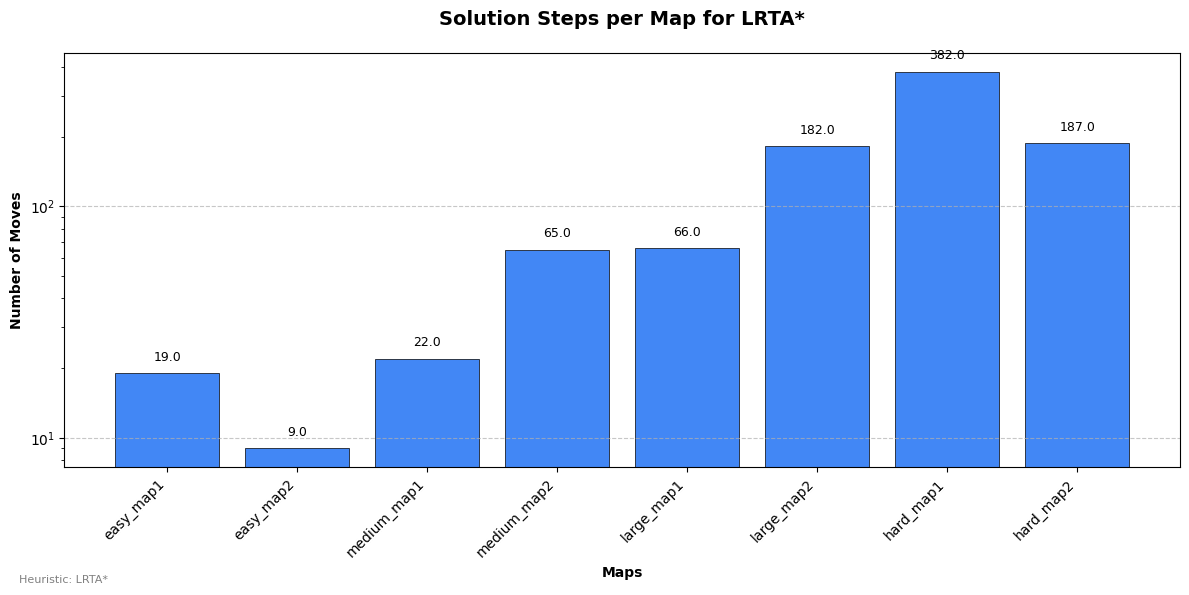

In [30]:
results1 = {}
results2 = {}

for map_name, map in MAPS.items():
    solver1 = Solver(map.copy(), 'lrta_star')
    solver1.h = h1
    solver1.c = c1
    s1, count1, duration1, pulls1 = solver1.solve()

    solver2 = Solver(map.copy(), 'lrta_star')
    solver2.h = h3
    solver2.c = c3
    s2, count2, duration2, pulls2 = solver2.solve()

    results1[map_name] = {
        'count': count1,
        'duration': duration1,
        'pulls': pulls1
    }
    results2[map_name] = {
        'count': count2,
        'duration': duration2,
        'pulls': pulls2
    }

fig, axes = plot_single_result(
    results2,
    characteristic='count',
    heuristic_name='LRTA*',
    title=f'Solution Steps per Map for LRTA*',
    log_scale=True
)
plt.show()

Way better, this solution is the best possible one.

### Analysis

Putting the first heuristic near the third one, we can see the following:

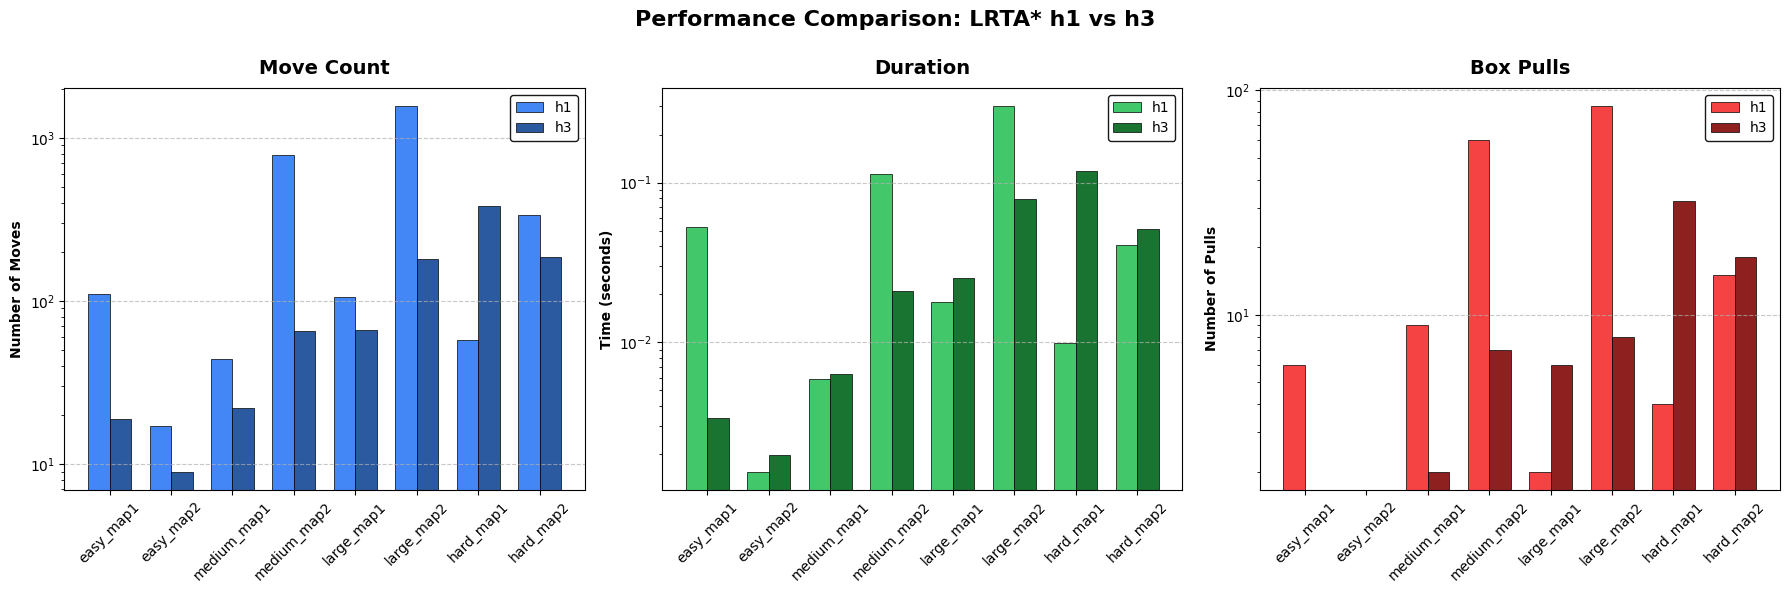

In [31]:
fig, axes = plot_all_characteristics(
    results1,
    results2,
    heuristic_names=('h1', 'h3'),
    title='Performance Comparison: LRTA* h1 vs h3',
    log_scale=True
)
plt.show()

We can see that there is an improvement on average for the third heuristic. Als, note that I chose to use logarithmic scale, in order to scale down the values.

The gif of the first map can be seen in `main.py`.

## Part 2: Beam Search

This section is dedicated to implementing the Beam Search algorithm.

### Intuition (Knowing what we want from LRTA*)

In order to implement the Beam Search algorithm, we should note the following:
1. The algorithm should stop on success, not in a local minima. Because of that, never go in a previously visited state (keep a Set of visited states).
2. Use the third heuristic function from the LRTA* algorithm. Because of how the algorithm works, other heuristics will loop indefinitely.

For beam, search, I did not include a pulls analysis because it would have been too complex for our small implementation.

We can perform different tests for different values of the beam width K. The results are the following (a value of K under 6 is too small for the last tests):

In [32]:
map = MAPS['easy_map1']
solver = Solver(map, 'beam_search')

solver.h, solver.c, solver.K = h3, c3, 6
states, count, duration, pulls = solver.solve(display=True)

Algorithm: beam_search
States explored: 93
Duration: 0.0066 seconds
Pulls: 0
Solution found: True


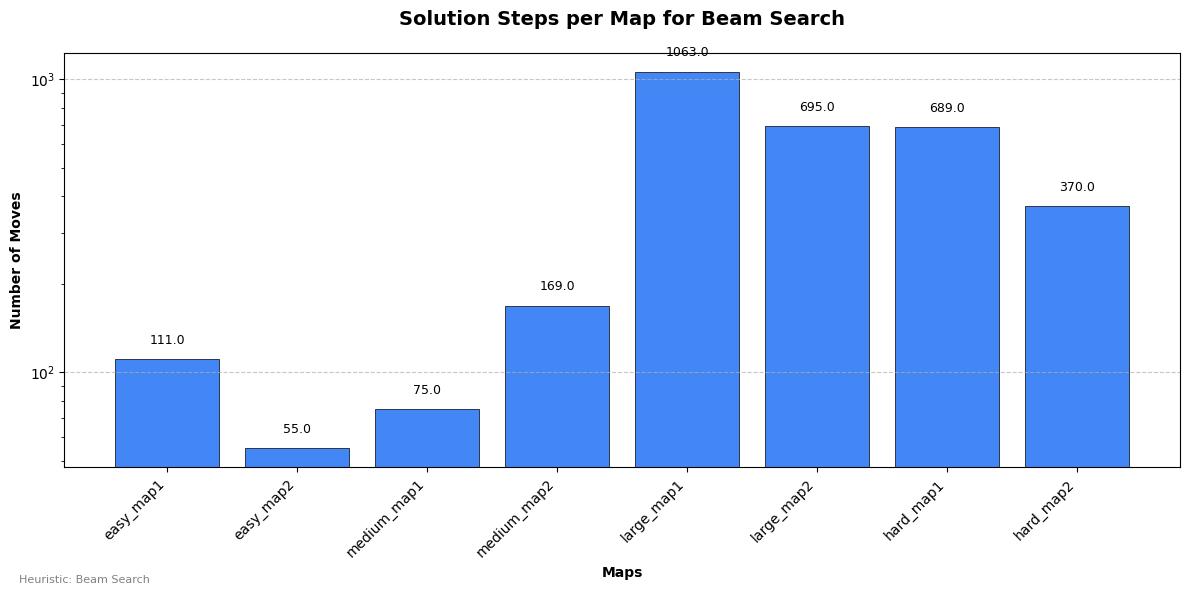

In [33]:
results1_bs = {}
results2_bs = {}

for map_name, map in MAPS.items():
    solver1 = Solver(map.copy(), 'beam_search')
    solver1.h, solver1.c, solver1.K = h3, c3, 6
    s1, count1, duration1, pulls1 = solver1.solve()

    solver2 = Solver(map.copy(), 'beam_search')
    solver2.h, solver2.c, solver2.K = h3, c3, 8
    s2, count2, duration2, pulls2 = solver2.solve()

    results1_bs[map_name] = {
        'count': count1,
        'duration': duration1,
        'pulls': pulls1
    }
    results2_bs[map_name] = {
        'count': count2,
        'duration': duration2,
        'pulls': pulls2
    }

fig, axes = plot_single_result(
    results2_bs,
    characteristic='count',
    heuristic_name='Beam Search',
    title=f'Solution Steps per Map for Beam Search',
    log_scale=True
)
plt.show()

/Users/matei/Desktop/sokoban/analysis/utils.py:153: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log', base=10)


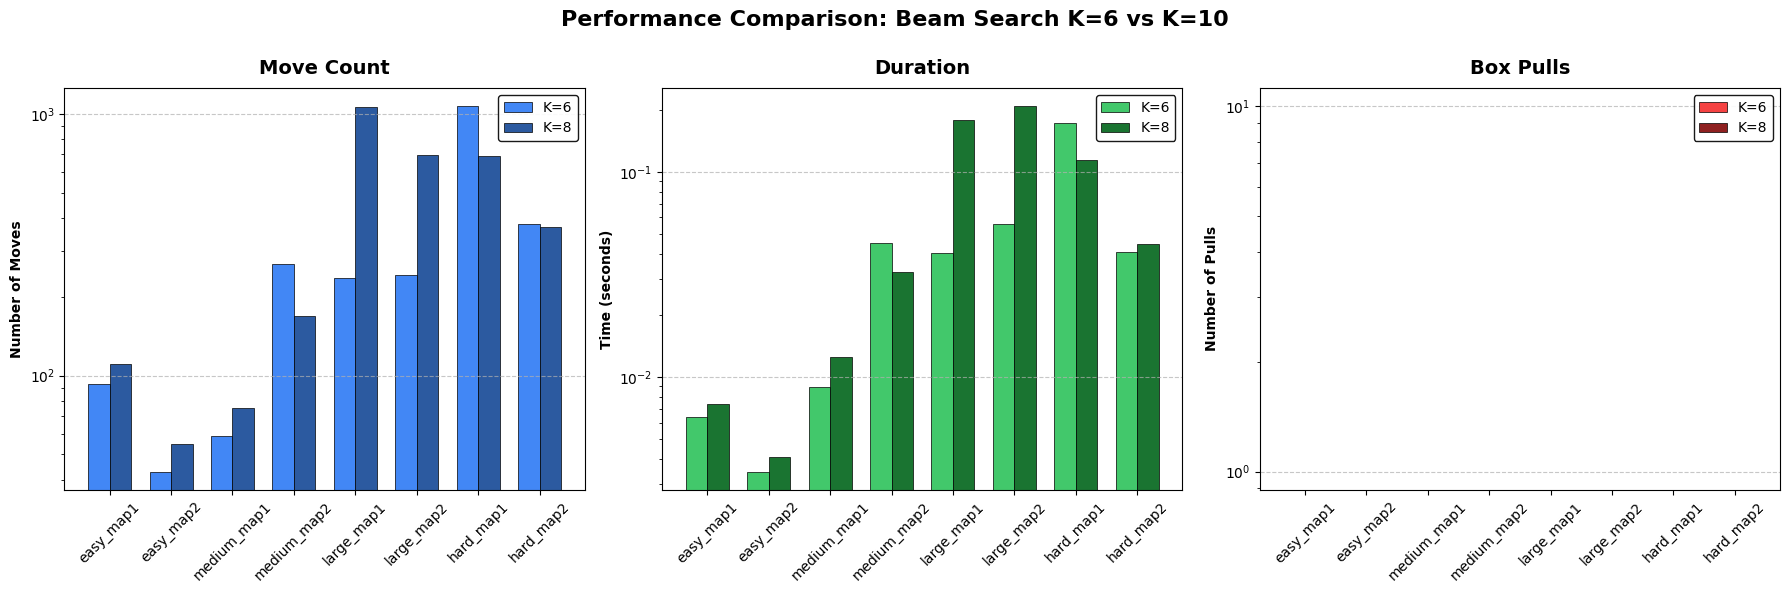

In [34]:
fig, axes = fig, axes = plot_all_characteristics(
    results1_bs,
    results2_bs,
    heuristic_names=('K=6', 'K=8'),
    title='Performance Comparison: Beam Search K=6 vs K=10',
    log_scale=True
)
plt.show()

We can see that, for our case, a value smaller than 6 is taking way too long and a value larger than 6 does not improve the results. The best value is 6, which is also the default one.

## Comparison: LRTA* vs Beam Search

We can put the two algorithms against each other. The results are the following:

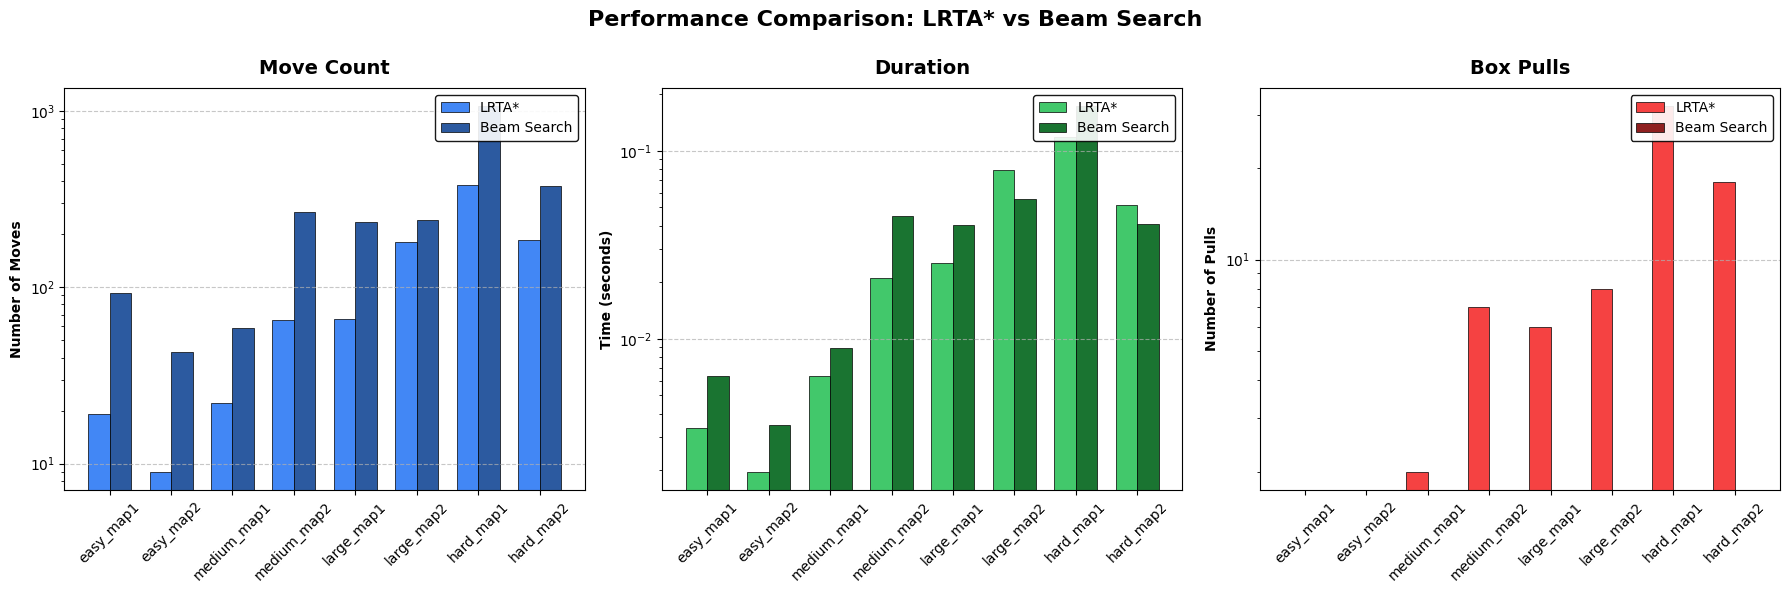

In [35]:
fig, axes = fig, axes = plot_all_characteristics(
    results2,
    results1_bs,
    heuristic_names=('LRTA*', 'Beam Search'),
    title='Performance Comparison: LRTA* vs Beam Search',
    log_scale=True
)
plt.show()

## Conclusion

The LRTA* algorithm is the best one for this case. The Beam Search algorithm is not very efficient and it does not improve the results, but can be used for other cases.

## Images

Here is a "GIF" of the first simulation of LRTA* on the second map:

Algorithm: lrta_star
States explored: 9
Duration: 0.0021 seconds
Pulls: 0
Solution found: True


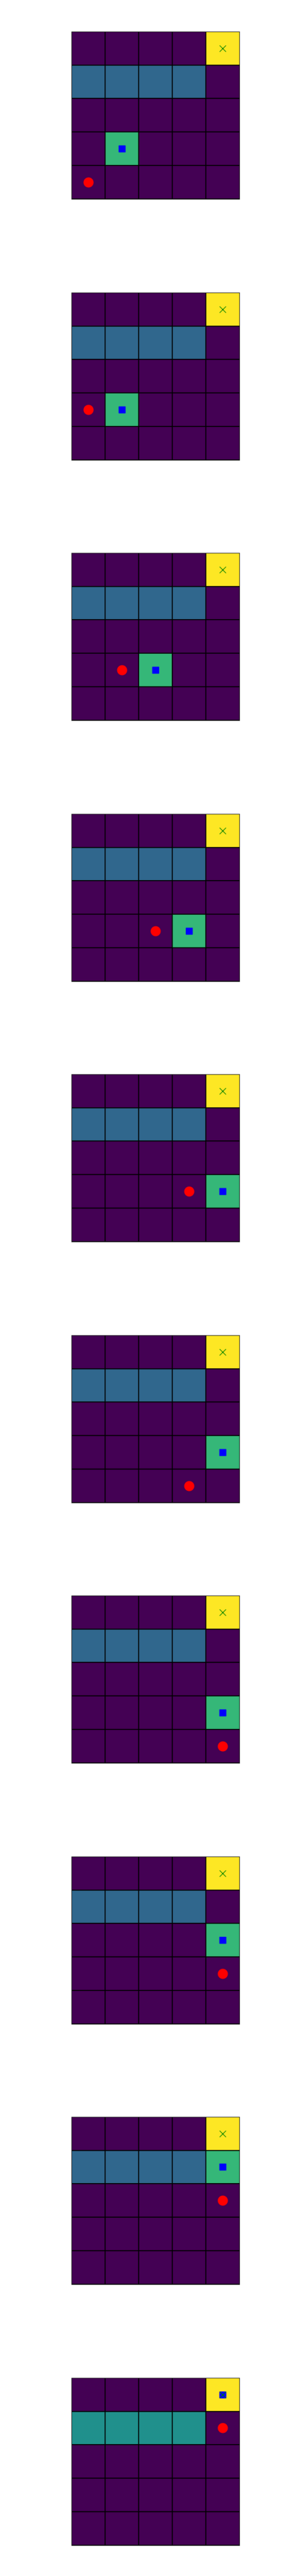

In [52]:
import os
from PIL import Image

from sokoban.gif import save_images

map = MAPS['easy_map2']
solver = Solver(map.copy(), 'lrta_star')
solver.h, solver.c = h3, c3

states, count, duration, pulls = solver.solve(display=True)

# Animate the solution
save_images(states, 'images/map2_images/')

images = []
for image in os.listdir('images/map2_images/'):
    if image.endswith('.png'):
        image_path = os.path.join('images/map2_images/', image)
        image = Image.open(image_path)
        images.append(image)

images.sort(key=lambda x: x.filename)
fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(25, 50))

if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.axis('off')
